# Wstęp
Zadanie 11 jest drugą częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.   EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2. Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3. Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem drugiego etapu prac jest przygotowanie modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. Dopuszczalne jest rozwiązanie, które działa podobnie jak klasyfikator z poprzedniego zadania, przy czym w tym wypadku skonstruowany zostanie regresor, a zmienną predykowaną będzie np. średni kurs w następnym dniu pod warunkiem obserwacji z dni poprzednich. 

# Warunki zaliczenia

Do zaliczenia drugiego etapu należy wykonać następujące kroki:

1.   Klasyfikacja zbioru tweetów przy pomocy 2 modeli EmoTweet opracowanych w etapie nr 1 (gdyby sieci LSTM były zbyt wolne, można użyć modeli opartych o fastText).
2.   Przygotowanie modelu LSTM, dla którego każdy element sekwencji będzie multimodalny, tj. będzie opisany cechami pochodzącymi z różnych źródeł:
   * Dane z giełdy kryptowalutowej
   * Zagregowane wartości emocji z tweetów

# Zbiór tweetów

Zbiór tweetów pochodzi z serwisu [Twitter](https://twitter.com/) i jest podzbiorem 2 milionów wiadomości dotyczących [Bitcoina](https://en.wikipedia.org/wiki/Bitcoin) z okresu od stycznia 2018 do maja 2020 roku. 
## Pobranie

In [1]:
!wget http://jankocon.clarin-pl.eu/share/bitcoin_tweets_2M.csv.7z

--2023-05-28 16:09:44--  http://jankocon.clarin-pl.eu/share/bitcoin_tweets_2M.csv.7z
Resolving jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)... 156.17.135.1
Connecting to jankocon.clarin-pl.eu (jankocon.clarin-pl.eu)|156.17.135.1|:80... connected.
HTTP request sent, awaiting response... 503 Service Unavailable
2023-05-28 16:11:51 ERROR 503: Service Unavailable.



## Rozpakowanie

In [ ]:
!7za x bitcoin_tweets_2M.csv.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 97590055 bytes (94 MiB)

Extracting archive: bitcoin_tweets_2M.csv.7z
--
Path = bitcoin_tweets_2M.csv.7z
Type = 7z
Physical Size = 97590055
Headers Size = 146
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      2% - bitcoin_tweets_2M.csv                              5% - bitcoin_tweets_2M.csv                              8% - bitcoin_tweets_2M.csv                             11% - bitcoin_tweets_2M.csv                             14% - bitcoin_tweets_2M.csv  

In [1]:
!git clone https://github.com/facebookresearch/fastText.git

Cloning into 'fastText'...
remote: Enumerating objects: 3938, done.
remote: Counting objects: 100% (966/966), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 3938 (delta 870), reused 824 (delta 819), pack-reused 2972
Receiving objects: 100% (3938/3938), 8.25 MiB | 3.03 MiB/s, done.
Resolving deltas: 100% (2508/2508), done.
Updating files: 100% (526/526), done.


In [2]:
!cd fastText && mkdir build && cd build && cmake ..  && make && make install

CMake Deprecation Warning at CMakeLists.txt:9 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.3.0
-- The CXX compiler identification is GNU 11.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (1.3s)
-- Generating done (0.2s)
-- Build files have been written to: /app/fastText/build
[  2%] Building CXX object CMakeFiles/fasttext-shared.dir/src/args.cc.o
[  

In [1]:
!cd fastText && pip install .

Processing /app/fastText
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4211758 sha256=b91370b0c3275745ab325a213b90a1c2b1939d3a6b99222fe546bafb2168b95f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2wm_vxxq/wheels/34/9a/79/ffb29de213ba6929d4e91e57b406e6f9ba1b7eba23dfa5c47d
Successfully built fasttext


In [3]:
import fasttext
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

help(fasttext.FastText)

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

MODEL_PATH = "dane/fasttext_tweetmodel_btc_sg_20_en.bin"
FT_MODEL_PATH = "dane/fasttext_tweetmodel_btc_sg_20_en.bin"
model = fasttext.load_model(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Help on module fasttext.FastText in fasttext:

NAME
    fasttext.FastText

DESCRIPTION
    # Copyright (c) 2017-present, Facebook, Inc.
    # All rights reserved.
    #
    # This source code is licensed under the MIT license found in the
    # LICENSE file in the root directory of this source tree.

FUNCTIONS
    cbow(*kargs, **kwargs)
    
    load_model(path)
        Load a model given a filepath and return a model object.
    
    read_args(arg_list, arg_dict, arg_names, default_values)
    
    skipgram(*kargs, **kwargs)
    
    supervised(*kargs, **kwargs)
    
    tokenize(text)
        Given a string of text, tokenize it and return a list of tokens
    
    train_supervised(*kargs, **kwargs)
        Train a supervised model and return a model object.
        
        input must be a filepath. The input text does not need to be tokenized
        as per the tokenize function, but it must be preprocessed and encoded
        as UTF-8. You might want to consult standard preprocessi

In [4]:
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence


class TextInferenceDataset(Dataset):
    def __init__(self, texts, model):
        self.model = model
        self.texts = [
            self.preprocess(text) for text in tqdm(texts, desc="Processing texts")
        ]

    def preprocess(self, text):
        return [self.model.get_word_vector(word) for word in fasttext.tokenize(text)]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": torch.tensor(self.texts[idx], dtype=torch.float),
            "length": len(self.texts[idx]),
        }


def pad_collate(batch):
    batch.sort(key=lambda x: x["length"], reverse=True)
    sequences, lengths = zip(*[(item["text"], item["length"]) for item in batch])
    sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    lengths = torch.tensor(lengths)

    return {"text": sequences, "length": lengths}


def get_inference_dataloader(model_path, texts):
    model = fasttext.load_model(model_path)

    dataset = TextInferenceDataset(texts, model)
    dataloader = DataLoader(dataset, batch_size=32, collate_fn=pad_collate)

    return dataloader, model.get_dimension()

## Zawartość
Dane zawierają następujące kolumny:
* `timestamp` - data wysłania wiadomości
* `likes` - liczba polubień wiadomości
* `retweets` - liczba przekazań dalej wiadomości
* `username` - nick użytkownika
* `text` - tekst tweeta "zanonimizowany" przy pomocy metody [`preprocess`](https://github.com/cardiffnlp/tweeteval/blob/main/TweetEval_Tutorial.ipynb), która była użyta przy tworzeniu zbioru [TweetEval](https://github.com/cardiffnlp/tweeteval)

In [5]:
import pandas as pd

tweets_data = pd.read_csv("dane/bitcoin_tweets_2M.csv")
tweets_data

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


# Dane z giełdy [Bitstamp](https://www.bitstamp.net/)
Zbiór pochodzi z serwisu Bitstamp i zawiera informacje o kursie Bitcoina od stycznia 2017 roku do kwietnia 2021 roku, zarówno w interwałach jednodniowych (24h), jak też godzinowych (1h).

## Pobranie 


In [ ]:
!wget http://jankocon.clarin-pl.eu/share/bitstamp.7z

## Rozpakowanie

In [6]:
!7za x bitstamp.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,16 CPUs 13th Gen Intel(R) Core(TM) i5-13400F (B06F2),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         
ERROR: No more files
bitstamp.7z



System ERROR:
Unknown error -2147024872


## Zawartość
Kwoty są podane w dolarach amerykańskich (kurs BTC/USD). Daty wyznaczają moment zamknięcia, a momentem otwarcia jest godzina wstecz (wariant 1h) lub dzień wstecz (wariant 24h). Każdy ze zbiorów zawiera następujące kolumny:
* `timestamp` - data w [formacie Unix](https://www.epochconverter.com/) 
* `date` - j.w. w formacie YYYY-MM-DD HH:MM:SS
* `open` - kurs otwarcia 
* `high` - najwyższa wartość 
* `low` - najniższa wartość 
* `close` - kurs zamknięcia
* `volume` - wolumen obrotu BTC

Interwał godzinowy:



In [6]:
bitstamp_data_1h = pd.read_csv(
    "dane/Bitstamp_BTCUSD_1h_2017_2018_2019_2020_2021-04-08.csv"
)
bitstamp_data_1h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,966.99,964.60,966.60,102.484806
1,1483232400,2017-01-01 01:00:00,966.60,966.60,962.54,963.87,149.025554
2,1483236000,2017-01-01 02:00:00,964.35,965.75,961.99,963.97,94.267396
3,1483239600,2017-01-01 03:00:00,963.88,964.71,960.53,962.83,77.619667
4,1483243200,2017-01-01 04:00:00,960.61,963.64,960.60,963.46,46.810220
...,...,...,...,...,...,...,...
37387,1617822000,2021-04-07 19:00:00,55832.62,56127.66,55441.93,56127.66,289.995730
37388,1617825600,2021-04-07 20:00:00,56075.95,56242.37,55690.00,56204.82,175.990086
37389,1617829200,2021-04-07 21:00:00,56243.09,56401.40,56053.20,56199.64,281.857236
37390,1617832800,2021-04-07 22:00:00,56160.72,56549.00,56111.13,56449.54,117.778871


Interwał dzienny:

In [12]:
bitstamp_data_24h = pd.read_csv(
    "dane/Bitstamp_BTCUSD_24h_2017_2018_2019_2020_2021-04-08.csv"
)
bitstamp_data_24h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,1005.00,960.53,997.75,6850.593309
1,1483315200,2017-01-02 00:00:00,997.75,1032.00,990.01,1012.54,8167.381030
2,1483401600,2017-01-03 00:00:00,1011.44,1039.00,999.99,1035.24,9089.658025
3,1483488000,2017-01-04 00:00:00,1035.51,1139.89,1028.56,1114.92,21562.456972
4,1483574400,2017-01-05 00:00:00,1114.38,1136.72,885.41,1004.74,36018.861120
...,...,...,...,...,...,...,...
1553,1617408000,2021-04-03 00:00:00,58967.61,59801.39,56922.00,57064.42,1663.268353
1554,1617494400,2021-04-04 00:00:00,57064.13,58501.00,56466.25,58212.18,1440.631820
1555,1617580800,2021-04-05 00:00:00,58213.69,59280.00,56800.00,59125.00,2402.437135
1556,1617667200,2021-04-06 00:00:00,59135.36,59473.90,57216.00,58018.30,2711.397847


# Realizacja zadania

Szczegółowa realizacja zadania powinna zawierać następujące etapy:

## Przygotowanie danych (5 pkt.)


1.   Wykorzystać modele utworzone w etapie 1 do opisania wymiarami afektywnymi (ZJAWISKO_1 oraz ZJAWISKO_2) zbioru tweetów `tweets_data`.
2.   Wyodrębnić podzbiór danych `bitstamp_data_*` z okresu dla którego są dostępne tweety.
3.   Dokonać agregacji informacji afektywnej dla interwału godzinowego oraz interwału dziennego. Przykładowo, jeżeli rozpatruję interwał dzienny, to dla kursu z daty zamknięcia 2017-01-02 00:00:00 agreguję informację afektywną z tweetów pojawiających się pomiędzy 2017-01-01 00:00:00 a 2017-01-02 00:00:00. Dodatkowo dokonać agregacji dodatkowych metadanych opisujących tweety, tj. `likes` oraz `retweets`. Metoda agregacji jest dowolna. Przykładowe możliwości:
 * suma
 * średnia
 * histogram
4.   Dokonać podziału danych na zbiór uczący (80%), walidacyjny (10%) oraz testowy (10%) poprzez wyznaczenie 2 punktów podziału na osi czasu (dane są ułożone chronologicznie). Innymi słowy, uczenie i strojenie modelu odbywa się na danych historycznych, a testowanie na aktualnych. 

In [8]:
import torch
from torch import nn
from tqdm.auto import tqdm


class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, lengths):
        packed_x = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, _) = self.lstm(packed_x)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return nn.functional.softmax(output, dim=1)


num_epochs = 100
hidden_dim = 50
dropout_rate = 0.5
embedding_dim = 20
output_dim = 2
hate_model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
).to(device)
offensive_model = LSTMClassifier(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
).to(device)

hate_model.load_state_dict(torch.load("hate_lstm_model.pt"))
offensive_model.load_state_dict(torch.load("offensive_lstm_model.pt"))

hate_model.eval()
offensive_model.eval()


def add_predicted_emotions(texts: list[str]) -> tuple[pd.Series, pd.Series]:
    hate_predictions_list = []
    offensive_predictions_list = []
    dataloader, input_dim = get_inference_dataloader(MODEL_PATH, texts)

    for batch in tqdm(dataloader, desc="Processing predictions"):
        text = batch["text"].to(device)
        length = batch["length"]

        with torch.no_grad():
            hate_predictions = hate_model(text, length)
            offensive_predictions = offensive_model(text, length)

        hate_classes = hate_predictions.argmax(dim=1).cpu().numpy()
        offensive_classes = offensive_predictions.argmax(dim=1).cpu().numpy()

        hate_predictions_list.extend(hate_classes.tolist())
        offensive_predictions_list.extend(offensive_classes.tolist())

    return pd.Series(hate_predictions_list), pd.Series(offensive_predictions_list)

In [9]:
from typing import Literal
from tqdm.auto import tqdm


def clear_btc_data(btc: pd.DataFrame) -> pd.DataFrame:
    btc_df = btc.copy()
    btc_df.dropna(inplace=True)
    btc_df["timestamp"] = pd.to_datetime(btc_df["timestamp"], unit="s")

    return btc_df.reset_index(drop=True)


def clear_tweets_data(tweets_df: pd.DataFrame) -> pd.DataFrame:
    tweets_df_copy = tweets_df.copy()
    tweets_df_copy.drop(columns=["username"], inplace=True)
    tweets_df_copy.dropna(inplace=True)

    tweets_df_copy["timestamp"] = pd.to_datetime(tweets_df_copy["timestamp"])
    tweets_df_copy["timestamp"] = tweets_df_copy["timestamp"].apply(
        lambda x: x.strftime("%Y-%m-%d %H:%M:%S")
    )

    return tweets_df_copy.reset_index(drop=True)


def adjust_starting_date(
    tweets: pd.DataFrame, btc: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    tweets_df = tweets.copy()
    btc_df = btc.copy()
    tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"])
    btc_df["timestamp"] = pd.to_datetime(btc_df["timestamp"])

    btc_df["timestamp"] = btc_df["timestamp"].dt.floor("min")
    starting_date_tweets = tweets_df["timestamp"].min()
    starting_date_btc = btc_df["timestamp"].min()
    latest_starting_date = max(starting_date_tweets, starting_date_btc)

    tweets_df = tweets_df[tweets_df["timestamp"] >= latest_starting_date]
    btc_df = btc_df[btc_df["timestamp"] >= latest_starting_date]

    return tweets_df, btc_df


def adjust_ending_date(
    tweets: pd.DataFrame, btc: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    tweets_df = tweets.copy()
    btc_df = btc.copy()
    tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"])
    btc_df["timestamp"] = pd.to_datetime(btc_df["timestamp"])

    btc_df["timestamp"] = btc_df["timestamp"].dt.floor("min")
    ending_date_tweets = tweets_df["timestamp"].max()
    ending_date_btc = btc_df["timestamp"].max()
    latest_ending_date = min(ending_date_tweets, ending_date_btc)

    tweets_df = tweets_df[tweets_df["timestamp"] <= latest_ending_date]
    btc_df = btc_df[btc_df["timestamp"] <= latest_ending_date]

    return tweets_df, btc_df


def adjust_for_date(
    tweets: pd.DataFrame, btc: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    tweets_df = tweets.copy()
    btc_df = btc.copy()
    tweets_df, btc_df = adjust_starting_date(tweets_df, btc_df)
    tweets_df, btc_df = adjust_ending_date(tweets_df, btc_df)
    return tweets_df, btc_df


def aggregate_tweets(
    tweets: pd.DataFrame, frequency: Literal["D", "H"]
) -> pd.DataFrame:
    tweets_df = tweets.copy()

    if tweets_df["timestamp"].dtype != "datetime64[ns]":
        tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"])

    tweets_df.set_index("timestamp", inplace=True)
    tweets_df.drop(columns=["text"], inplace=True)
    aggregated_df = tweets_df.resample(frequency).sum()
    aggregated_df.reset_index(inplace=True)

    return aggregated_df


def merge_data(
    tweets: pd.DataFrame, btc: pd.DataFrame, frequency: Literal["D", "H"]
) -> None:
    tweets_df = tweets.copy()
    btc_df = btc.copy()

    timed_tweets_df = aggregate_tweets(tweets_df, frequency)
    timed_tweets_df, timed_btc_df = adjust_for_date(timed_tweets_df, btc_df)

    timed_df = timed_tweets_df.merge(timed_btc_df, on="timestamp", how="inner")
    timed_df.drop(columns=["date"], inplace=True)
    return timed_df


def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    timed_df = df.sort_values("timestamp")
    train_size = int(len(timed_df) * 0.8)
    validation_size = int(len(timed_df) * 0.1)

    train = timed_df[:train_size]
    validation = timed_df[train_size : (train_size + validation_size)]
    test = timed_df[(train_size + validation_size) :]
    return train, validation, test

In [172]:
btc_df_24h = clear_btc_data(bitstamp_data_24h)
btc_df_1h = clear_btc_data(bitstamp_data_1h)
tweets_df = clear_tweets_data(tweets_data)

In [10]:
import os

file_path = "dane/tweets_emotions.csv"

if not os.path.exists(file_path):
    texts = tweets_df["text"].tolist()
    hate_predictions, offensive_predictions = add_predicted_emotions(texts)
    tweets_df["hate"] = hate_predictions
    tweets_df["offensive"] = offensive_predictions
    tweets_df.to_csv(file_path, index=False)

In [76]:
if os.path.exists(file_path):
    tweets_df = pd.read_csv(file_path)

daily_df = merge_data(tweets_df, btc_df_24h, "D")
hourly_df = merge_data(tweets_df, btc_df_1h, "H")
print(daily_df.head(5))
print(hourly_df.head(5))

daily_file_path = "dane/daily_tweets_emotions.csv"
hourly_file_path = "dane/hourly_tweets_emotions.csv"

daily_df.to_csv(daily_file_path, index=False)
hourly_df.to_csv(hourly_file_path, index=False)

   timestamp  likes  retweets  hate  offensive      open      high       low   
0 2018-01-01   8653      3564   239        233  13880.00  13941.75  12801.38  \
1 2018-01-02  11396      4074   277        317  13394.20  15257.53  12910.58   
2 2018-01-03  11290      6263   289        325  14670.96  15500.00  14546.28   
3 2018-01-04  12657      4459   164        206  15155.62  15430.27  14192.37   
4 2018-01-05  13348      6001   277        368  15143.67  17200.00  14810.00   

      close        volume  
0  13443.41   7688.030685  
1  14678.94  16299.669303  
2  15155.62  12275.001197  
3  15143.67  15004.018593  
4  16928.00  16248.914680  
            timestamp  likes  retweets  hate  offensive      open      high   
0 2018-01-01 00:00:00    214        38     8         12  13880.00  13906.37  \
1 2018-01-01 01:00:00    923       157     6          7  13635.06  13704.42   
2 2018-01-01 02:00:00    171        42     6          4  13355.00  13536.88   
3 2018-01-01 03:00:00     97       

## Budowanie modeli (5 pkt.)

Model ma służyć do przewidywania kursu **w przyszłości** na podstawie danych **historycznych**. W każdym badaniu w sekcji **Ewaluacja modeli** należy sprawdzić jakość predykcji na 2 typach modeli:
1. **Model dzienny** - model, który w chwili T przewiduje (do wyboru jedna z opcji):
 * kurs zamknięcia w chwili T+1
 * średni kurs dla okresu od T do T+1 (wymaga obliczenia na podstawie danych godzinowych)
2. **Model godzinowy** - model, który w chwili T przewiduje kurs zamknięcia dla okresu T+1. 

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:
1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


In [15]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.3
    ):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.dropout_prob = dropout_prob

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(
            hidden_size * 2 if self.bidirectional else hidden_size, output_size
        )

    def forward(self, x):
        h0 = torch.zeros(
            self.num_layers * 2 if self.bidirectional else self.num_layers,
            x.size(0),
            self.hidden_size,
        ).to(x.device)
        c0 = torch.zeros(
            self.num_layers * 2 if self.bidirectional else self.num_layers,
            x.size(0),
            self.hidden_size,
        ).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [170]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_squared_error


def create_sequences(input_data: torch.Tensor, output_data: torch.Tensor, tw: int):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = output_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq


def prepare_data(
    timed_df: pd.DataFrame, scaler: MinMaxScaler, sequence_length: int, scale = True
) -> DataLoader:
    df = timed_df.copy()
    df = df.drop(columns=["timestamp"])
    targets = df["close"].values
    features = df.drop(columns=["close"])
    
    if scale:
        features = scaler.transform(features)
    else:
        features = features.apply(pd.to_numeric, errors='coerce')
        features = features.replace([np.inf, -np.inf], np.nan)
        features = features.dropna()
        features = features.to_numpy()
        features = features.astype(float)

    features = torch.tensor(features, dtype=torch.float).to(device)
    targets = torch.tensor(targets, dtype=torch.float).to(device)

    sequences = create_sequences(features, targets, sequence_length)

    dataloader = DataLoader(sequences, batch_size=32, shuffle=False)

    return dataloader


def get_scaler(train_df: pd.DataFrame) -> MinMaxScaler:
    df = train_df.copy()
    df = df.drop(columns=["timestamp", "close"])
    scaler = MinMaxScaler()
    scaler.fit(df)

    return scaler

In [17]:
def train_epoch(model, criterion, optimizer, dataloader, device):
    model.train()
    epoch_loss = 0.0
    y_pred, y_true = [], []
    for seq, labels in dataloader:
        seq = seq.to(device)
        labels = labels.to(device)

        model.zero_grad()
        output = model(seq)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        y_pred.extend(output.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    epoch_r2 = r2_score(y_true, y_pred)
    return epoch_loss, epoch_r2


def validate_epoch(model, criterion, dataloader, device):
    model.eval()
    epoch_loss = 0.0
    y_pred, y_true = [], []
    with torch.no_grad():
        for seq, labels in dataloader:
            seq = seq.to(device)
            labels = labels.to(device)

            output = model(seq)
            loss = criterion(output, labels)

            y_pred.extend(output.detach().cpu().numpy())
            y_true.extend(labels.detach().cpu().numpy())

            epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    epoch_r2 = r2_score(y_true, y_pred)
    return epoch_loss, epoch_r2


def train_model(
    model,
    criterion,
    optimizer,
    dataloader,
    val_dataloader,
    test_dataloader,
    device,
    epochs,
    patience,
):
    train_losses = []
    val_losses = []
    test_losses = []
    train_accs = []
    val_accs = []
    test_accs = []
    min_val_loss = np.inf
    patience_counter = 0

    scheduler = ReduceLROnPlateau(optimizer, "min", patience=patience, verbose=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_r2 = train_epoch(
            model, criterion, optimizer, dataloader, device
        )
        train_losses.append(train_loss)
        train_accs.append(train_r2)

        val_loss, val_r2 = validate_epoch(model, criterion, val_dataloader, device)
        val_losses.append(val_loss)
        val_accs.append(val_r2)
        scheduler.step(val_loss)

        test_loss, test_r2 = validate_epoch(model, criterion, test_dataloader, device)
        test_losses.append(test_loss)
        test_accs.append(test_r2)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping on epoch {epoch}")
                break

    results = {
        "best_model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "test_accs": test_accs,
    }

    return best_model, results

In [139]:
import matplotlib.pyplot as plt


def plot_losses_and_accuracies(results):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results["train_losses"], label="Train Loss")
    plt.plot(results["val_losses"], label="Validation Loss")
    plt.plot(results["test_losses"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training, Validation, and Test Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results["train_accs"], label="Train Accuracy")
    plt.plot(results["val_accs"], label="Validation Accuracy")
    plt.plot(results["test_accs"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training, Validation, and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def prepare_input_data(timed_df: pd.DataFrame, scaler: MinMaxScaler, sequence_length: int):
    df = timed_df.copy()
    df = df.drop(columns=["timestamp", "close"])
    array_features = scaler.transform(df)
    return array_features


def predict_value(model: LSTM, input_sequence):
    with torch.no_grad():
        model.eval()
        prediction = model(input_sequence)
    return prediction.item()


def predict_value_from_index(model: LSTM, df: pd.DataFrame, index: int):
    if index <= 0 or index >= len(df):
        return 0
    
    seq_len = 6
    price_to_predict = df.iloc[index]["close"]
    scaled_ndarray = prepare_input_data(df, scaler, seq_len)
    input_data = scaled_ndarray[:index]
    input_data = input_data[-seq_len:]
    input_tensor = torch.tensor(input_data, dtype=torch.float).unsqueeze(0).to(device)
    predicted_value = predict_value(model, input_tensor)

    print(f"The predicted close price for the next hour is: {predicted_value} True Value is {price_to_predict}") 
    
    
def print_metrics(results):
    for data_set in ["train", "val", "test"]:
        print(f"{data_set} => mse: {results[data_set + '_losses'][-1]}, r2: {results[data_set + '_accs'][-1]}")

In [161]:
def test_hyperparams(timed_df: pd.DataFrame, hyperparams: dict, scale_data = True, print_results = True):
    train_df, val_df, test_df = split_data(timed_df)
    scaler = get_scaler(train_df)
    dataloader = prepare_data(train_df, scaler, hyperparams['sequence_length'], scale_data)
    val_dataloader = prepare_data(val_df, scaler, hyperparams['sequence_length'], scale_data)
    test_dataloader = prepare_data(test_df, scaler, hyperparams['sequence_length'], scale_data)

    model = LSTM(hyperparams['input_size'], hyperparams['hidden_size'], hyperparams['num_layers'], hyperparams['output_size'], hyperparams['dropout_prob']).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

    best_model, results = train_model(
        model,
        criterion,
        optimizer,
        dataloader,
        val_dataloader,
        test_dataloader,
        device,
        hyperparams['epochs'],
        hyperparams['patience'],
    )

    if print_results:
        plot_losses_and_accuracies(results)
        predict_value_from_index(model, timed_df, len(timed_df) - 1)
        print_metrics(results)
        
    return results

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 206


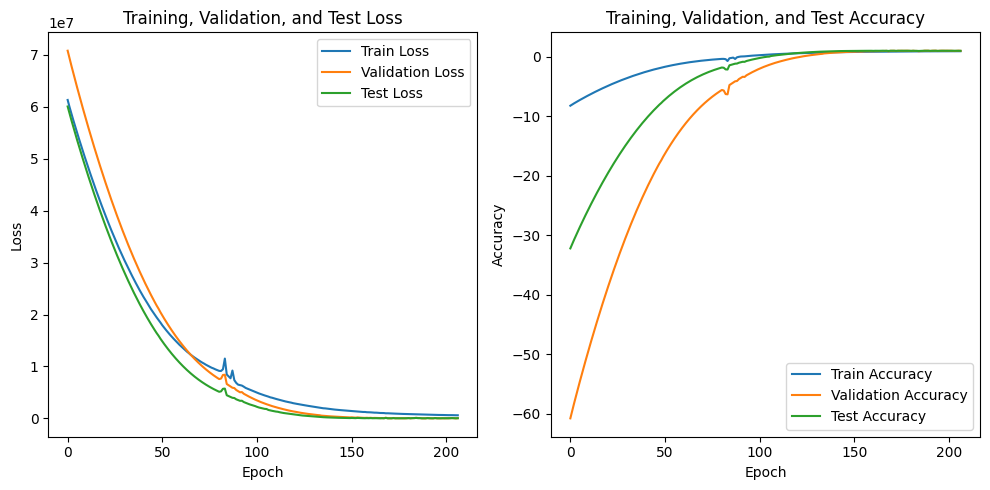

The predicted close price for the next hour is: 9289.5751953125 True Value is 9421.04
train => mse: 595578.7350260416, r2: 0.9101599317606386
val => mse: 35740.41844223485, r2: 0.9687825965329913
test => mse: 30009.494673295456, r2: 0.9834190017172757


In [142]:
hyperparams = {
    'input_size': 8,
    'hidden_size': 100,
    'num_layers': 2,
    'output_size': 1,
    'dropout_prob': 0.3,
    'learning_rate': 0.001,
    'sequence_length': 5,
    'epochs': 500,
    'patience': 10
}

test_hyperparams(hourly_df, hyperparams)

  0%|          | 0/2500 [00:00<?, ?it/s]

Early stopping on epoch 2056


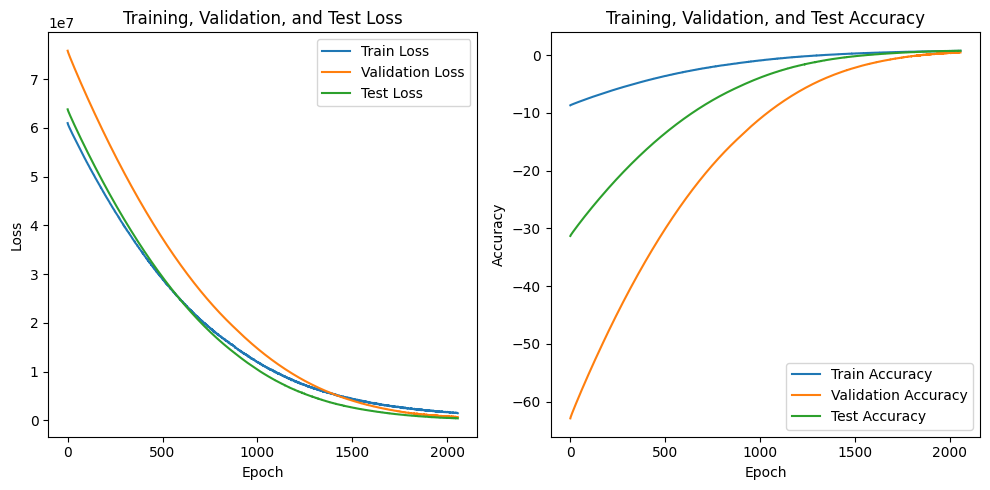

The predicted close price for the next hour is: 8365.4130859375 True Value is 9421.04
train => mse: 1477915.0459872158, r2: 0.764147287470651
val => mse: 681588.0260416666, r2: 0.4844659619166789
test => mse: 418993.515625, r2: 0.7805909917114695


In [148]:
hyperparams = {
    'input_size': 8,
    'hidden_size': 150,
    'num_layers': 2,
    'output_size': 1,
    'dropout_prob': 0.3,
    'learning_rate': 0.001,
    'sequence_length': 5,
    'epochs': 2500,
    'patience': 10
}


test_hyperparams(daily_df, hyperparams)

In [152]:
sequence_lengths = [2, 6, 10, 20]

hyperparams = {
    'input_size': 8,
    'hidden_size': 100,
    'num_layers': 2,
    'output_size': 1,
    'dropout_prob': 0.3,
    'learning_rate': 0.001,
    'sequence_length': 5,
    'epochs': 500,
    'patience': 10
}

test_accs = []
test_losses = []
for seq in sequence_lengths:
    hyperparams[sequence_length] = seq
    results = test_hyperparams(hourly_df, hyperparams, True, False)
    test_accs.append(results['test_accs'])
    test_losses.append(results['test_losses'])

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 190


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 193


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 192


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 190


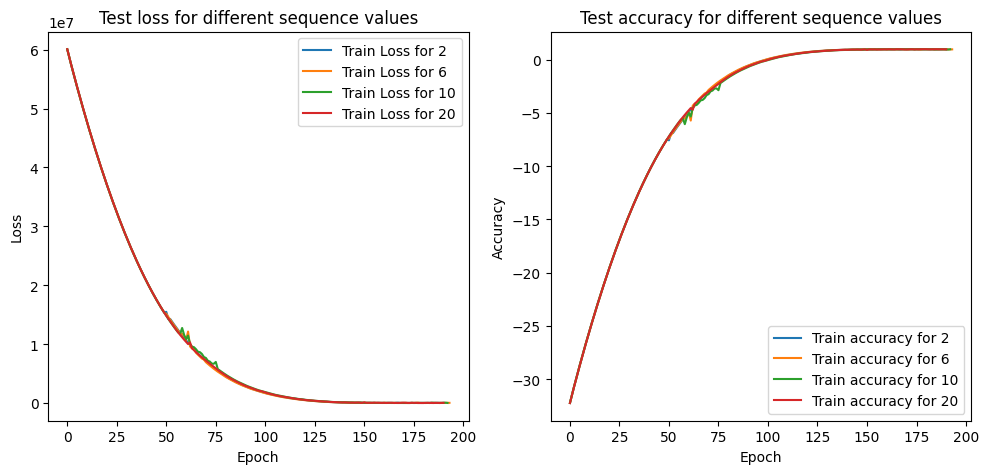

In [159]:
def show_params_plot(params, test_losses, test_accs, param_name: str):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    for param, loss in zip(params, test_losses):
        plt.plot(loss, label=f"Train Loss for {param}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Test loss for different {param_name} values")
    plt.legend()

    plt.subplot(1, 2, 2)
    for param, acc in zip(params, test_accs):
        plt.plot(acc, label=f"Train accuracy for {param}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Test accuracy for different {param_name} values")
    plt.legend()

    plt.tight_layout()
    plt.show()

show_params_plot(sequence_lengths, test_losses, test_accs, "sequence")

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 109


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 188


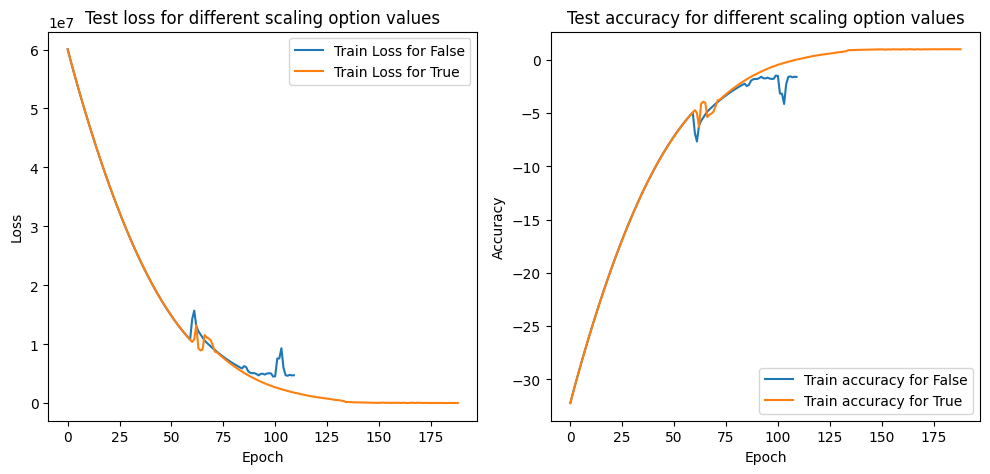

In [171]:
hyperparams = {
    'input_size': 8,
    'hidden_size': 100,
    'num_layers': 2,
    'output_size': 1,
    'dropout_prob': 0.3,
    'learning_rate': 0.001,
    'sequence_length': 5,
    'epochs': 500,
    'patience': 10
}

test_accs = []
test_losses = []
for should_scale in [False, True]:
    results = test_hyperparams(hourly_df, hyperparams, should_scale, False)
    test_accs.append(results['test_accs'])
    test_losses.append(results['test_losses'])

show_params_plot([False, True], test_losses, test_accs, "scaling option")

  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 273


  0%|          | 0/500 [00:00<?, ?it/s]

Early stopping on epoch 197


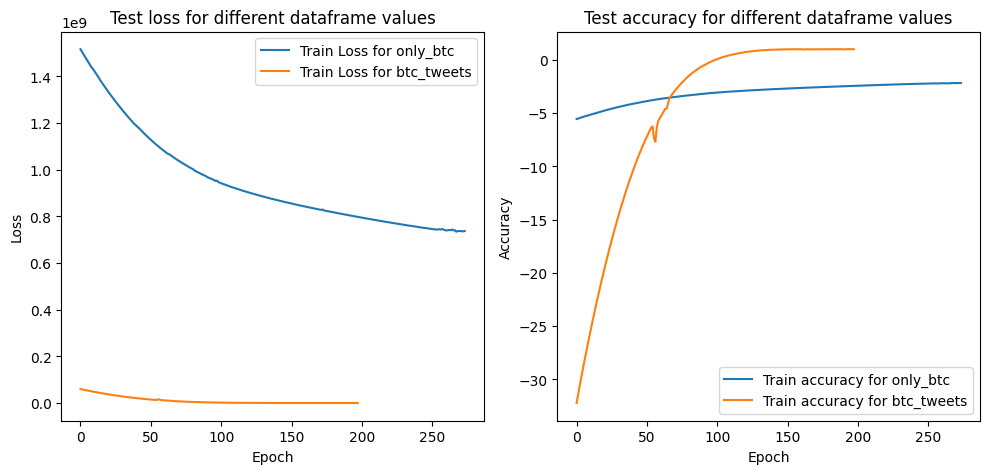

In [179]:
hyperparams = {
    'input_size': 8,
    'hidden_size': 100,
    'num_layers': 2,
    'output_size': 1,
    'dropout_prob': 0.3,
    'learning_rate': 0.001,
    'sequence_length': 5,
    'epochs': 500,
    'patience': 10
}

if "date" in btc_df_1h.columns:
    btc_df_1h = btc_df_1h.drop(columns=["date"])

test_accs = []
test_losses = []
for i, data in enumerate([btc_df_1h, hourly_df]):
    if i == 0:
        hyperparams['input_size'] = 4
    else:
        hyperparams['input_size'] = 8
    results = test_hyperparams(data, hyperparams, True, False)
    test_accs.append(results['test_accs'])
    test_losses.append(results['test_losses'])

show_params_plot(["only_btc", "btc_tweets"], test_losses, test_accs, "dataframe")